In [4]:
from loader import PMNISTDataSet
from shapely import geometry, affinity, wkt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import os, json

In [5]:
class PolyMNIST(object):
    def __init__(self, path):
        with open(os.path.join(path, "mnist_polygon_test.json"), 'r') as infile:
            self.plist = json.load(infile)
        with open(os.path.join(path, "mnist_label_test.json"), 'r') as infile:
            self.label = json.load(infile)
    def __getitem__(self, idx):
        P = wkt.loads(self.plist[idx])
        V, E = poly2ve(P)
        return V, E, self.label[idx]
    
    def get_poly(self, idx):
        P = wkt.loads(self.plist[idx])
        return P
    
    def get_label(self, idx):
        return self.label[idx]

class CPolygon(object):
    def __init__(self, polygon, C):
        self.polygon = polygon
        self.V, self.E, self.E_segs = self.getVE()
        self.npoly = len(self.E_segs)
        self.C = C
        self.W = None # shape (#V, #C)
        self.dVdC = None # shape (#V, 2, #C, 3)
        self._update_weights()
        
    def update_control(self, dC, rad=True):
        """dC: shape (#C, 3), where 3 dims are x, y, theta"""
        assert(self.C.shape[0] == dC.shape[0])
        dtheta = dC[:, 2].copy()
        dC = dC[:, :2].copy()
        if not rad:
            dtheta = dtheta / 180 * np.pi
        Vnew = np.zeros_like(self.V)
        for i in range(dtheta.shape[0]):
            t = dtheta[i]
            Rot = np.array([[np.cos(t), -np.sin(t)],
                            [np.sin(t), np.cos(t)]])
            a, b = self.C[i]
            Rot_trans = np.array([-a*np.cos(t)+b*np.sin(t)+a,
                                  -a*np.sin(t)-b*np.cos(t)+b])
            Vnew += self.W[:, i:i+1] * (self.V.dot(Rot.T) + dC[i] + Rot_trans)
        self.V = Vnew # update vertices
        self.C += dC # update control points
        self.polygon = self.newPolygon(self.V) # update polygon
        self._update_weights() # update wights and sensitivity matrix

    def _update_weights(self):
        self.W = np.zeros([self.V.shape[0], self.C.shape[0]])
        for i in range(self.W.shape[0]):
            for j in range(self.W.shape[1]):
                v = self.V[i]
                c = self.C[j]
                self.W[i,j] = 1/(np.linalg.norm(c-v)**2)
        # normalize
        self.W = (self.W.T / np.sum(self.W, axis=1)).T
        # compute sensitivity matrix
        nV = self.V.shape[0]
        nC = self.C.shape[0]
        self.dVdC = np.zeros([nV, 2, nC, 3])
        vx, vy = self.V[:, 0:1], self.V[:, 1:2]
        cx, cy = self.C[:, 0], self.C[:, 1]
        # d vx / d cx
        self.dVdC[:, 0, :, 0] = self.W
        # d vy / d cy
        self.dVdC[:, 1, :, 1] = self.W
        # d vx / d ctheta
        self.dVdC[:, 0, :, 2] = self.W * (-vy+cy)
        # d vy / d ctheta
        self.dVdC[:, 1, :, 2] = self.W * (vx-cx)
        
        
    def edgeList(self, startid, length, flip=False):
        # helper function to create edge list
        p1 = np.arange(startid, startid+length)
        p2 = p1 + 1
        p2[-1] = startid
        if not flip:
            return np.stack((p1, p2), axis=-1)
        else:
            return np.flipud(np.stack((p2, p1), axis=-1))
        
    def singlePolygon(self, P):
        # helper function for processing a single polygon instance
        assert(isinstance(P, geometry.polygon.Polygon))
        v = []
        e = []
        ecount = 0
        # exterior
        v_ex = np.array(P.exterior)[:-1]
        e_ex = self.edgeList(0, v_ex.shape[0])
        v.append(v_ex)
        e.append(e_ex)
        ecount += v_ex.shape[0]
        # interiors
        for int_ in P.interiors:
            v_in = np.array(int_)
            e_in = self.edgeList(ecount, v_in.shape[0], flip=False)
            v.append(v_in)
            e.append(e_in)
            ecount += v_in.shape[0]
        v = np.concatenate(v, axis=0)
        e_segs = e
        e = np.concatenate(e, axis=0)
        if not P.exterior.is_ccw:
            e = np.concatenate([e[:, 1:2], e[:, 0:1]], axis=-1) # flip e
        return v, e, e_segs
    
    def getVE(self):
        E_segs = []
        if isinstance(self.polygon, geometry.polygon.Polygon):
            V, E, e_segs = self.singlePolygon(self.polygon)
            E_segs.append(e_segs)
        elif isinstance(self.polygon, geometry.multipolygon.MultiPolygon):
            V = []
            E = []
            E_segs = []
            ecount = 0
            for P in self.polygon.geoms:
                v, e, e_segs = self.singlePolygon(P)
                V.append(v)
                E.append(e+ecount)
                for s in e_segs:
                    s += ecount
                E_segs.append(e_segs)
                ecount += v.shape[0]
            V = np.concatenate(V, axis=0)
            E = np.concatenate(E, axis=0)
            
        return V, E, E_segs
    
    def newPolygon(self, V):
        np.testing.assert_array_equal(V.shape, self.V.shape)
        polys = []
        for loops in self.E_segs:
            # exterior loop
            ext_loop = loops[0][:, 0]
            ext_v = geometry.asLinearRing(V[ext_loop])
            ints_v = []
            for i in range(1, len(loops)):
                int_loop = loops[i][:, 0]
                int_v = geometry.asLinearRing(V[int_loop])
                ints_v.append(int_v)
            poly = geometry.Polygon(ext_v, ints_v)
            polys.append(poly)
        if len(polys) == 1:
            return polys[0]
        else:
            return geometry.MultiPolygon(polys)

from matplotlib import pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from numpy import asarray, concatenate, ones
from shapely.geometry import *
        
def ring_coding(ob):
    # The codes will be all "LINETO" commands, except for "MOVETO"s at the
    # beginning of each subpath
    n = len(ob.coords)
    codes = ones(n, dtype=Path.code_type) * Path.LINETO
    codes[0] = Path.MOVETO
    return codes

def pathify(polygon):
    # Convert coordinates to path vertices. Objects produced by Shapely's
    # analytic methods have the proper coordinate order, no need to sort.
    vertices = concatenate(
                    [asarray(polygon.exterior)]
                    + [asarray(r) for r in polygon.interiors])
    codes = concatenate(
                [ring_coding(polygon.exterior)]
                + [ring_coding(r) for r in polygon.interiors])
    return Path(vertices, codes)        

def showPolygon(polygon, figsize=(4,4)):
    fig = plt.figure(num=1, figsize=figsize)
    ax = fig.add_subplot(111)

    path = pathify(polygon)
    patch = PathPatch(path, facecolor='#cccccc', edgecolor='#999999')

    ax.add_patch(patch)

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_aspect(1.0)
    
    return fig, ax  

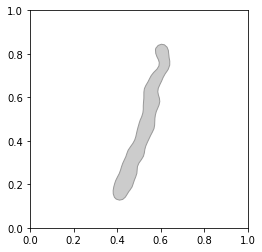

In [10]:
pmnist = PolyMNIST("data/polyMNIST")
P = pmnist.get_poly(2)
C = np.array([[0.6, 0.8],
              [0.55, 0.65],
              [0.45, 0.2]])
P = CPolygon(P, C)
# showPolygon(P.polygon)
dC = np.array([[ 0, 0, 30],
               [ 0, 0,  0],
               [ 0, 0,  0]])

P.update_control(dC, rad=False)

fig, _ = showPolygon(P.polygon)

plt.show()